# **ML Pipeline: Predict Sale Price**

## Objectives

* Fit and evaluate a regression model that will predict the Sale Price of a house in Ames, Iowa
* Create an ML Pipeline including data cleaning, feature engineering and ML model steps

## Inputs

* outputs/datasets/collection/HousePriceRecords.csv
* Data Cleaning and Feature Engineering steps found in previous notebooks

## Outputs

* TrainSet
* TestSet
* Regression Piepline
* Feature importance Plot

## CRISP-DM

* Modelling
* Evaluation


---

# Change working directory

* The notebooks are stored in a sub folder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/milestone-project-heritage-housing-issues/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/milestone-project-heritage-housing-issues'

# Load Data

In [4]:
import pandas as pd
df = pd.read_csv(f"outputs/datasets/collection/HousePriceRecords.csv")
df.head(5)

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,68.0,162.0,42,5,7,920,NaN,2001,2002,223500
3,961,NaN,NaN,No,216,ALQ,540,NaN,642,Unf,...,60.0,0.0,35,5,7,756,NaN,1915,1970,140000
4,1145,NaN,4.0,Av,655,GLQ,490,0.0,836,RFn,...,84.0,350.0,84,5,8,1145,NaN,2000,2000,250000


### Load variables

* Below we will declare the relevant variables as decided upon on the Data Cleaning and Feature Engineering notebooks.

* Data Cleaning

In [5]:
arbitrary_imputation_vars = ['2ndFlrSF', 'EnclosedPorch', 'WoodDeckSF']
median_imputation_vars = ['BedroomAbvGr', 'LotFrontage', 'GarageYrBlt',
                          'MasVnrArea']
most_frequent_vars = ['BsmtFinType1', 'GarageFinish']

* Categorical Encoding

In [6]:
categorical_encoding_vars = (df.select_dtypes(include=['object'])
                             .columns.to_list())
categorical_encoding_vars

['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual']

* Feature Engineering

In [7]:
log_transformation_vars = ['1stFlrSF', 'LotArea']
power_vars = ['2ndFlrSF', 'BsmtFinSF1', 'BsmtUnfSF',
              'GarageArea', 'MasVnrArea', 'TotalBsmtSF']
yeojohnson_vars = ['GrLivArea']

# Create ML Pipeline
* We create the base for the ML Pipeline
* We inlcude the steps for Data Cleaning Feature Engineering, Feature Scaling, Feature Selection and the ML model we decide upon
* We will use Hyperparameter Optimization to choose the best model and most effective hyperparamters

In [8]:
from sklearn.pipeline import Pipeline

from feature_engine.imputation import (MeanMedianImputer,
                                       ArbitraryNumberImputer,
                                       CategoricalImputer)

# Feature Engineering
from feature_engine.selection import SmartCorrelatedSelection
from feature_engine.encoding import OrdinalEncoder
from feature_engine import transformation as vt
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from feature_engine.outliers import Winsorizer


def PipelineRegressor(model):
    pipeline_base = Pipeline([

        # Data Cleaning
        ("ArbitraryImputer",
         ArbitraryNumberImputer(arbitrary_number=0,
                                variables=arbitrary_imputation_vars)),

        ("MedianImputation",
         MeanMedianImputer(imputation_method='median',
                           variables=median_imputation_vars)),

        ("CategoricalImputer",
         CategoricalImputer(imputation_method='frequent',
                            variables=most_frequent_vars)),

        # Feature Engineering
        ("OrdinalCategoricalEncoder",
         OrdinalEncoder(encoding_method='arbitrary',
                        variables=categorical_encoding_vars)),

        ("LogTransformer", vt.LogTransformer(
            variables=['1stFlrSF', 'LotArea'])),

        ("PowerTransformer", vt.PowerTransformer(variables=power_vars)),

        ("YeoJohnsonTransformer", vt.YeoJohnsonTransformer(
            variables=yeojohnson_vars)),

        ("Winsorizer", Winsorizer(capping_method='iqr', tail='both', fold=1.5,
                                  variables=['GrLivArea'])),

        ("SmartCorrelatedSelection",
         SmartCorrelatedSelection(variables=None, method="spearman",
                                  threshold=0.75,
                                  selection_method="variance")),

        # Feature Scaling
        ("scaler", StandardScaler()),

        # Feature Selection
        ("feat_selection", SelectFromModel(model)),

        # ML Algorithms
        ("model", model),
    ])

    return pipeline_base

* **Hyperparameter Optimization Search**
    * Below code taken from CI lesson: *Scikit-Learn Unit 6: Cross Validation Search Part 2*

In [9]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")

            model = PipelineRegressor(self.models[key])
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, )
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        columns = ['estimator', 'min_score', 'mean_score', 'max_score',
                   'std_score']
        columns = columns + [c for c in df.columns if c not in columns]
        return df[columns], self.grid_searches
        

# Split Train & Test Set

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
                                    df.drop(['SalePrice'], axis=1),
                                    df['SalePrice'],
                                    test_size=0.2,
                                    random_state=0,
                                    )

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1168, 23) (1168,) (292, 23) (292,)


* We import our potential Algorithms

In [11]:
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression

/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Scikit Learn Cross Validation Search

* We first search for the most suitable algorithm using tandard hyper parameters

In [12]:
models_quick_search = {
    "LogisticRegression": LogisticRegression(random_state=0,solver='liblinear'),
    "LinearRegression": LinearRegression(),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
}

params_quick_search = {
    "LogisticRegression": {},
    "LinearRegression": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "GradientBoostingClassifier": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
}

* We will include LogisticRegression in our first run. For this the max cross validation value we can have is cv=2.
* We will check how LogisticRegression performs against the other algorithms. If it is not the best performer, we will remove it from our search and run again with a greater cross validation value.

In [13]:
from sklearn.metrics import r2_score

search = HyperparameterOptimizationSearch(models=models_quick_search,
                                          params=params_quick_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=2)


Running GridSearchCV for LogisticRegression 

Fitting 2 folds for each of 1 candidates, totalling 2 fits


/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is depreca


Running GridSearchCV for LinearRegression 

Fitting 2 folds for each of 1 candidates, totalling 2 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for GradientBoostingRegressor 

Fitting 2 folds for each of 1 candidates, totalling 2 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for XGBRegressor 

Fitting 2 folds for each of 1 candidates, totalling 2 fits


/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprec


Running GridSearchCV for DecisionTreeRegressor 

Fitting 2 folds for each of 1 candidates, totalling 2 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for RandomForestRegressor 

Fitting 2 folds for each of 1 candidates, totalling 2 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for ExtraTreesRegressor 

Fitting 2 folds for each of 1 candidates, totalling 2 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for AdaBoostRegressor 

Fitting 2 folds for each of 1 candidates, totalling 2 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa

* We add the results to a DataFrame and assess.

In [14]:
import numpy as np
(grid_search_summary,
grid_search_pipelines) = search.score_summary(sort_by='mean_score')

print(grid_search_summary.shape)
grid_search_summary

(8, 5)


,estimator,min_score,mean_score,max_score,std_score
6,ExtraTreesRegressor,0.788895,0.807982,0.82707,0.019087
1,LinearRegression,0.784779,0.788555,0.79233,0.003775
2,GradientBoostingRegressor,0.752499,0.773725,0.794951,0.021226
7,AdaBoostRegressor,0.751549,0.75564,0.759731,0.004091
5,RandomForestRegressor,0.735608,0.754396,0.773184,0.018788
3,XGBRegressor,0.646058,0.692155,0.738252,0.046097
4,DecisionTreeRegressor,0.348319,0.504011,0.659703,0.155692
0,LogisticRegression,0.410919,0.445057,0.479194,0.034137


* LogisticRegression had the worst overall mean R2 score so we can remove it and run again with corss valdation value of cv=5
* We redefine our variables without LogisticRegression and complete another search

In [15]:
models_quick_search = {
    "LinearRegression": LinearRegression(),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
}

params_quick_search = {
    "LinearRegression": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "GradientBoostingClassifier": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
}

In [16]:
search = HyperparameterOptimizationSearch(models=models_quick_search,
                                          params=params_quick_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.In


Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa

* We check how the algorithms performed

In [17]:
(grid_search_summary,
grid_search_pipelines) = search.score_summary(sort_by='mean_score')

print(grid_search_summary.shape)
grid_search_summary

(7, 5)


,estimator,min_score,mean_score,max_score,std_score
5,ExtraTreesRegressor,0.741517,0.834506,0.875323,0.047543
4,RandomForestRegressor,0.705841,0.794745,0.836924,0.045953
0,LinearRegression,0.755444,0.791655,0.83202,0.030133
1,GradientBoostingRegressor,0.629836,0.773847,0.836809,0.073601
6,AdaBoostRegressor,0.676189,0.757328,0.802705,0.043541
2,XGBRegressor,0.61935,0.695526,0.748881,0.049904
3,DecisionTreeRegressor,0.501251,0.594329,0.725724,0.081102


* ExtraTreesRegressor has provided us with our best mean score of 0.83.
* This score is sufficient to meet the performance goal of our model as per our client's business case (R2 score > 0.75)
* Next we will try to fine tune our model through hyper parameter optimization.
* We will select a number of hyperparametrs to add to our regressor model and determine the most efficient combination.

In [18]:
models_search = {
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
}

params_search = {
    "ExtraTreesRegressor": {
        'model__max_depth': [int(x) for x in np.arange(start = 5, stop = 10, step = 1)],
        'model__min_impurity_decrease': [0.0,0.3,0.5],
        'model__min_samples_leaf': [0.3,0.5,1],
        'model__min_samples_split': [int(x) for x in np.arange(start = 3, stop = 7, step = 1)],
        'model__min_weight_fraction_leaf': [0.0,0.1,0.5],
        'model__n_estimators': [int(x) for x in np.arange(start = 50, stop = 100, step = 10)]}
}

* We perform another Cross Validation search using "LinearRegression" & "GradientBoostingRegressor" as our model and a set of hyperparameters to apply, in order to find the best hyperparameter permutation for our model

In [19]:
search = HyperparameterOptimizationSearch(models=models_search,
                                          params=params_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 2700 candidates, totalling 13500 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa

* We add the results to a DataFrame and assess

In [ ]:
(grid_search_summary,
grid_search_pipelines) = search.score_summary(sort_by='mean_score')

grid_search_summary.head()

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__max_features,model__min_impurity_decrease,model__min_samples_leaf,model__min_samples_split,model__min_weight_fraction_leaf,model__n_estimators
1414,ExtraTreesRegressor,0.64215,0.679845,0.709992,0.026103,2,None,0.3,1,5,0.0,90
1579,ExtraTreesRegressor,0.64215,0.679845,0.709992,0.026103,2,None,0.5,1,4,0.0,90
1429,ExtraTreesRegressor,0.64215,0.679845,0.709992,0.026103,2,None,0.3,1,6,0.0,90
1234,ExtraTreesRegressor,0.64215,0.679845,0.709992,0.026103,2,None,0.0,1,5,0.0,90
1609,ExtraTreesRegressor,0.64215,0.679845,0.709992,0.026103,2,None,0.5,1,6,0.0,90


* We can see that we have an improvement in the mean R2 score, bringing it up to 0.84
* We will use these hyperparameters for our model

* We print our best model below

In [ ]:
best_model = grid_search_summary.iloc[0, 0]
best_model

'ExtraTreesRegressor'

* We print our best combination of hyperparameters for our algorithm

In [ ]:
best_hyperparams = grid_search_pipelines[best_model].best_params_
best_hyperparams

{'model__max_depth': 2,
 'model__max_features': None,
 'model__min_impurity_decrease': 0.0,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 3,
 'model__min_weight_fraction_leaf': 0.0,
 'model__n_estimators': 90}

* We define our best pipeline at this stage

In [ ]:
pipeline_regressor = grid_search_pipelines[best_model].best_estimator_
pipeline_regressor

Pipeline(steps=[('ArbitraryImputer',
                 ArbitraryNumberImputer(arbitrary_number=0,
                                        variables=['2ndFlrSF', 'EnclosedPorch',
                                                   'WoodDeckSF'])),
                ('MedianImputation',
                 MeanMedianImputer(variables=['BedroomAbvGr', 'LotFrontage',
                                              'GarageYrBlt', 'MasVnrArea'])),
                ('CategoricalImputer',
                 CategoricalImputer(imputation_method='frequent',
                                    variables=['BsmtFinType1',
                                               'GarageFinish'...
                                                     'KitchenQual', 'LotArea',
                                                     'LotFrontage',
                                                     'MasVnrArea',
                                                     'OpenPorchSF',
                                                

# Measure performance on Train & Test Sets

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="whitegrid")


def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    print("Model Evaluation \n")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline)


def regression_evaluation(X, y, pipeline):
    prediction = pipeline.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))
    print('Root Mean Squared Error:',
          np.sqrt(mean_squared_error(y, prediction)).round(3))
    print("\n")


def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline,
                                alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 12))
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")

    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")

    plt.show()

Model Evaluation 

* Train Set
R2 Score: 0.691
Mean Absolute Error: 28844.064
Mean Squared Error: 1901556342.729
Root Mean Squared Error: 43606.838


* Test Set
R2 Score: 0.661
Mean Absolute Error: 28995.737
Mean Squared Error: 2341762566.312
Root Mean Squared Error: 48391.761




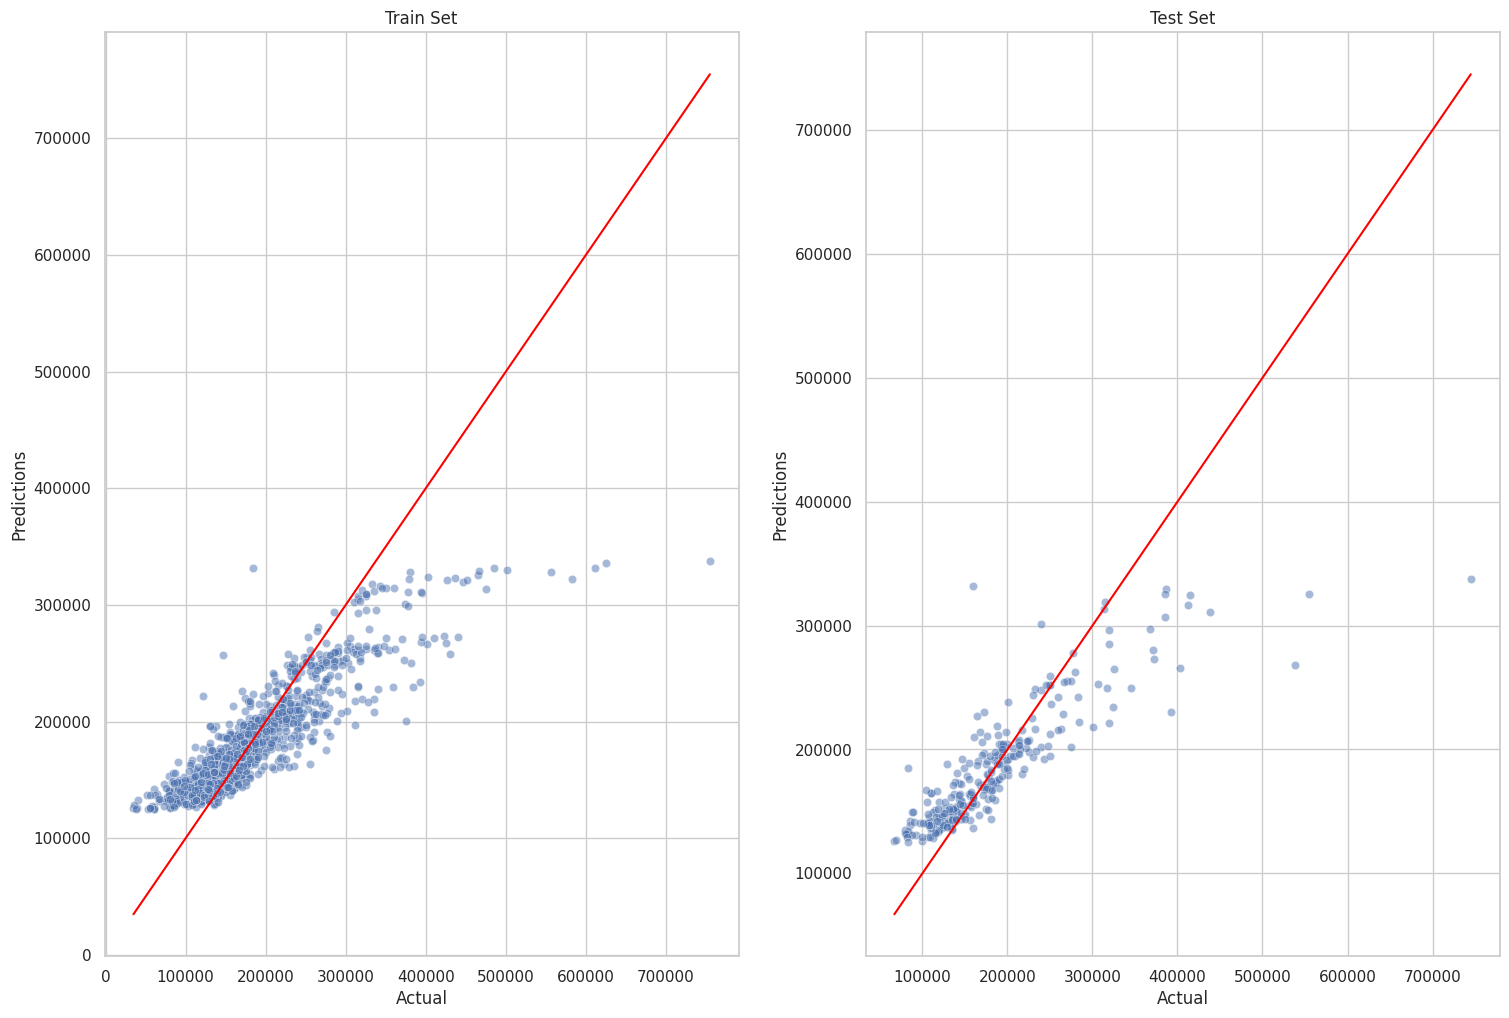

In [ ]:
regression_performance(X_train, y_train, X_test, y_test, pipeline_regressor)
regression_evaluation_plots(X_train, y_train, X_test, y_test,
                            pipeline_regressor)

* The R2 score on our test set is 0.856.
* This is an acceptable score, in the context of our business case, for our house price prediction model.

# Assess feature importance

* We are now interetsed to check which are the most important features for our pipeline and as our algorithm is Tree Based, we can access these using the 'feature_importances_' method.
    * The below code was taken from CI walthrough project: *Churnometer*

* These are the 6 most important features indescending order. The model was trained on them:
['OverallQual', 'GrLivArea', 'GarageArea', 'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF']


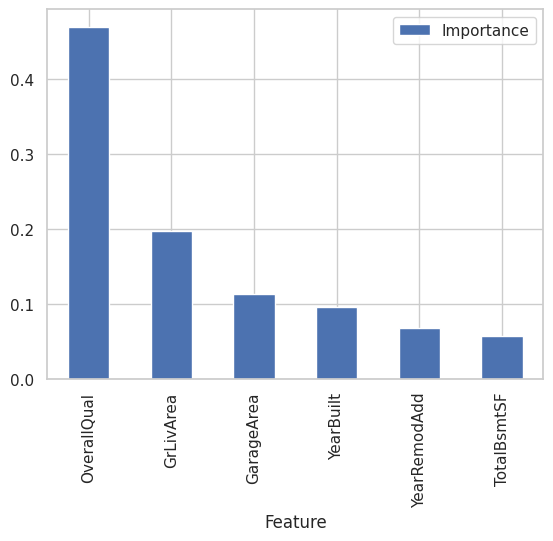

In [ ]:
# number of data cleaning and feature engineering in pipeline
data_cleaning_feat_eng_steps = 9
columns_after_data_cleaning_feat_eng = ((Pipeline(pipeline_regressor
                                        .steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns))

best_features = (columns_after_data_cleaning_feat_eng[pipeline_regressor
                 ['feat_selection'].get_support()].to_list())

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
          'Feature': (columns_after_data_cleaning_feat_eng
                      [pipeline_regressor['feat_selection'].get_support()]),
          'Importance': pipeline_regressor['model'].feature_importances_})
  .sort_values(by='Importance', ascending=False)
  )

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in" +
      f"descending order. "
      f"The model was trained on them:" +
      f"\n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

* The most important features for predicting 'SalePrice' will be printed out below

In [28]:
best_features

['GarageArea',
 'GrLivArea',
 'OverallQual',
 'TotalBsmtSF',
 'YearBuilt',
 'YearRemodAdd']

# Rewrite & Refit Pipeline with best features
* We rewrite our pipeline removing all steps whihc do not include our most important features.
* We also remove SmartCorelatedSelectio and Feature Selection. As we have our most important features, these are no longer necessary.
* We aim to streamline our pipeline to predict 'SalePrice' using fewer features.

In [ ]:
def PipelineRegressor(model):
    pipeline_base = Pipeline([
        ("PowerTransformer", vt.PowerTransformer(variables=['GarageArea',
                                                            'TotalBsmtSF'])),

        ("YeoJohnsonTransformer",
         vt.YeoJohnsonTransformer(variables=yeojohnson_vars)),

        ("Winsorizer", Winsorizer(capping_method='iqr', tail='both', fold=1.5,
                                  variables=['GrLivArea'])),
        ("scaler", StandardScaler()),
        ("model", model),
    ])

    return pipeline_base

# Evaluating on Train and Test Sets

* We split our Train & Test Sets again using only our most important features

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
                                    df.drop(['SalePrice'], axis=1),
                                    df['SalePrice'],
                                    test_size=0.2,
                                    random_state=0
                                    )

print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",
      X_test.shape, y_test.shape)

* Train set: (1168, 23) (1168,) 
* Test set: (292, 23) (292,)


In [ ]:
X_train = X_train.filter(best_features)
X_test = X_test.filter(best_features)

print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",
      X_test.shape, y_test.shape)
X_train.head(3)

* Train set: (1168, 6) (1168,) 
* Test set: (292, 6) (292,)


,GarageArea,GrLivArea,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd
618,774,1828,9,1822,2007,2007
870,308,894,5,894,1962,1962
92,432,964,5,876,1921,2006


# Grid Search

* We define our highest performing model and hyperparameters

In [ ]:
models_search = {
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0)
}

params_search = {
    "ExtraTreesRegressor": {
        'model__max_depth': [10],
        'model__min_impurity_decrease': [0.0],
        'model__min_samples_leaf': [1],
        'model__min_samples_split': [5],
        'model__min_weight_fraction_leaf': [0.0],
        'model__n_estimators': [100]}

}

params_search


{'ExtraTreesRegressor': {'model__max_depth': [10],
  'model__min_impurity_decrease': [0.0],
  'model__min_samples_leaf': [1],
  'model__min_samples_split': [5],
  'model__min_weight_fraction_leaf': [0.0],
  'model__n_estimators': [100]}}

* We assess the performance on the scaled down TrainSets

In [ ]:
search = HyperparameterOptimizationSearch(models=models_search,
                                          params=params_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [ ]:
(grid_search_summary,
grid_search_pipelines) = search.score_summary(sort_by='mean_score')

grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__min_impurity_decrease,model__min_samples_leaf,model__min_samples_split,model__min_weight_fraction_leaf,model__n_estimators
0,ExtraTreesRegressor,0.755863,0.842891,0.881047,0.044674,10,0.0,1,5,0.0,100


* Our R2 score remains at 0.84

* We define our best model and pipeline

In [ ]:
best_model = grid_search_summary.iloc[0, 0]
best_model

'ExtraTreesRegressor'

In [ ]:
pipeline_regressor = grid_search_pipelines[best_model].best_estimator_
pipeline_regressor

Pipeline(steps=[('PowerTransformer',
                 PowerTransformer(variables=['GarageArea', 'TotalBsmtSF'])),
                ('YeoJohnsonTransformer',
                 YeoJohnsonTransformer(variables=['GrLivArea'])),
                ('Winsorizer',
                 Winsorizer(capping_method='iqr', fold=1.5, tail='both',
                            variables=['GrLivArea'])),
                ('scaler', StandardScaler()),
                ('model',
                 ExtraTreesRegressor(max_depth=10, min_samples_split=5,
                                     random_state=0))])

* These are the 6 most important features in descending order. The model was trained on them: 
['OverallQual', 'GrLivArea', 'GarageArea', 'TotalBsmtSF', 'YearBuilt', 'YearRemodAdd']


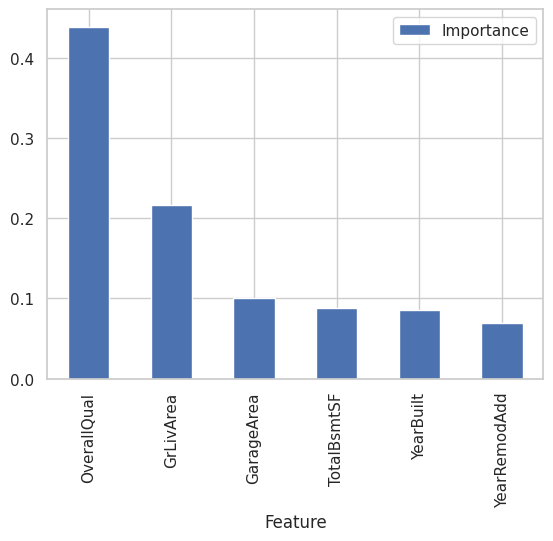

In [ ]:
# number of data cleaning and feature engineering in pipeline
data_cleaning_feat_eng_steps = 3
columns_after_data_cleaning_feat_eng = ((Pipeline(pipeline_regressor
                                        .steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns))

best_features = columns_after_data_cleaning_feat_eng

# # create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
          'Feature': columns_after_data_cleaning_feat_eng,
          'Importance': pipeline_regressor['model'].feature_importances_})
  .sort_values(by='Importance', ascending=False)
  )

# # Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.show()

* The feature importance remains the same

* We assess the performance on our TestSet

Model Evaluation 

* Train Set
R2 Score: 0.957
Mean Absolute Error: 11501.831
Mean Squared Error: 267735604.472
Root Mean Squared Error: 16362.628


* Test Set
R2 Score: 0.856
Mean Absolute Error: 19319.765
Mean Squared Error: 996860187.269
Root Mean Squared Error: 31573.093




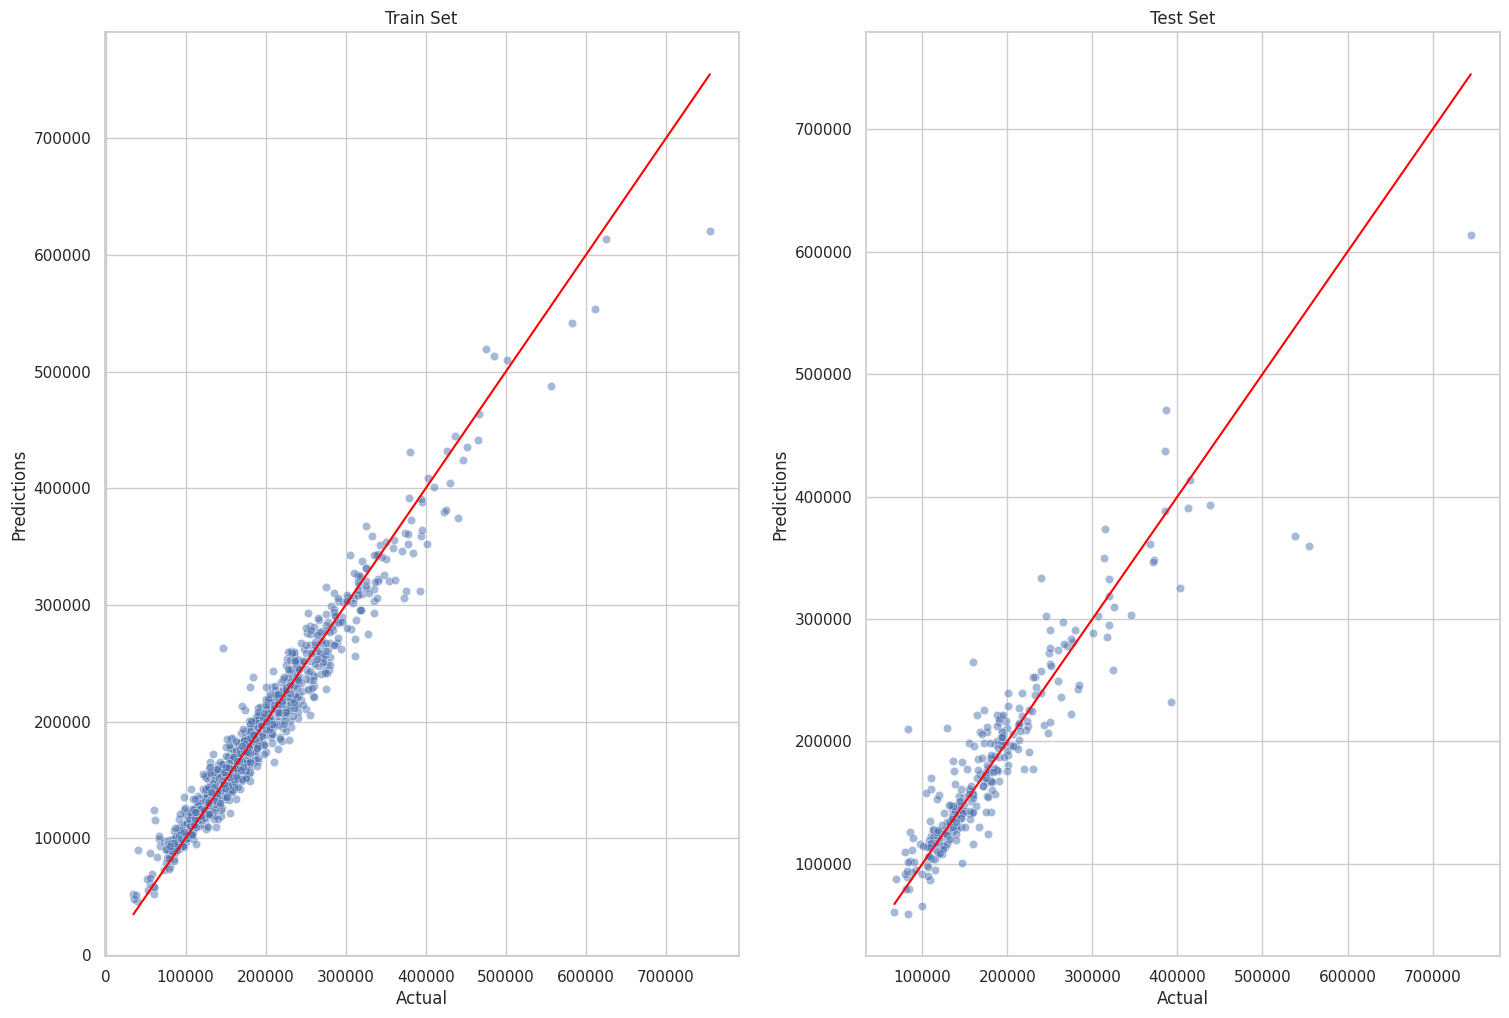

In [ ]:
regression_performance(X_train, y_train, X_test, y_test, pipeline_regressor)
regression_evaluation_plots(X_train, y_train, X_test, y_test,
                            pipeline_regressor)

* The R2 score remains at 0.856.
* We will push this pipeline to our repo for use in our dashboard app.

---

# Push files to Repo

We will generate the following files for our dashboard:

* Train set
* Test set
* Modelling Pipeline
* Fetaure Importance Plot

In [ ]:
import joblib

version = 'v3'
file_path = f"outputs/ml_pipeline/predict_saleprice/{version}"
try:
    os.makedirs(name=file_path)
except Exception as e:
    print(e)

### Train Set: features and target

In [ ]:
X_train.head(3)

In [ ]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)


### Test Set: features and target

In [ ]:
X_test.head(3)

In [ ]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

In [ ]:
y_train

In [ ]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

In [ ]:
y_test

In [ ]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

### Modelling Pipeline

* ML pipeline for SalePrice prediction

In [ ]:
pipeline_regressor

In [ ]:
joblib.dump(value=pipeline_regressor,
            filename=f"{file_path}/pipeline_regressor.pkl")

### Feature importance plot

In [ ]:
df_feature_importance.plot(kind='bar', x="Feature", y="Importance")
plt.savefig(f"{file_path}/features_importance.png", bbox_inches="tight",
            facecolor='white')